## _*LiH dissociation curve using NumPyMinimumEigensolver*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy and dipole moments of a Lithium Hydride (LiH) molecule over a range of inter-atomic distances.

This notebook has been written to use the PYSCF chemistry driver. 

In [35]:
import numpy as np
import pylab

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

from qiskit_algorithms import NumPyMinimumEigensolver


In [36]:
molecule = 'Li .0 .0 -{0}; H .0 .0 {0}'

algorithm = 'NumPyMinimumEigensolver'

# configure distance between two atoms
pts  = [x * 0.1  for x in range(6, 20)]
pts += [x * 0.25 for x in range(8, 17)]

distances   = np.empty(len(pts))
hf_energies = np.empty(len(pts))
energies    = np.empty(len(pts))

In [37]:
print('Processing step __', end='')
for i, d in enumerate(pts):
    print('\b\b{:2d}'.format(i), end='', flush=True)

    info = MoleculeInfo(["Li", "H"], [(0.0, 0.0, -d/2), (0.0, 0.0, d/2)])
    driver = PySCFDriver.from_molecule(info, basis="sto3g")
    molecule = driver.run()
    transformer = FreezeCoreTransformer()
    molecule = transformer.transform(molecule)
    hamiltonian = molecule.hamiltonian.second_q_op()
    mapper = ParityMapper(num_particles=molecule.num_particles)
    tapered_mapper = molecule.get_tapered_mapper(mapper)
    qubit_op = tapered_mapper.map(hamiltonian)

    if algorithm == 'NumPyMinimumEigensolver':
        algo = NumPyMinimumEigensolver()
        algo.filter_criterion = molecule.get_default_filter_criterion()
        solver = GroundStateEigensolver(mapper, algo)
        result = solver.solve(molecule)

    elif algorithm == 'VQE':
          pass

    distances[i] = d
    hf_energies[i] = result.hartree_fock_energy
    energies[i] = result.total_energies[0]

print(' --- complete')

Processing step 22 --- complete


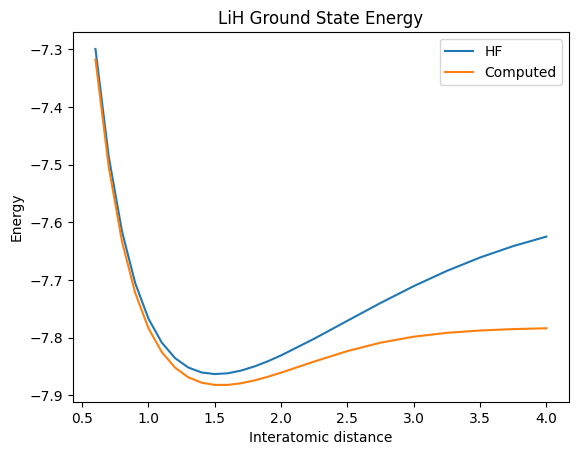

In [38]:
pylab.plot(distances, hf_energies, label='HF')
pylab.plot(distances, energies, label='Computed')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right');